In [0]:
import os
import collections
import networkx as nx
import numpy as np
import pandas as pd
import tqdm
from tqdm import tqdm_notebook

In [0]:
DATA_TYPE = 'small'
# DATA_TYPE = 'raw'

if DATA_TYPE == 'raw':
    DATA_NUM = 11881
    FEATURE_NUM = 9568
    CLASS_NUM = 10
else:
    DATA_NUM = 2708
    FEATURE_NUM = 1432
    CLASS_NUM = 7

In [0]:
data_dir = os.path.expanduser("./")
edgelist = pd.read_csv(os.path.join(data_dir, "edge_list.csv"), sep=',', header=0,names=["target", "source"])

Gnx = nx.Graph()
Gnx.add_nodes_from(range(DATA_NUM))
for index, row in edgelist.iterrows():
    Gnx.add_edge(row['target'], row['source'])

In [0]:
NODE_NUM = len(Gnx.nodes())

labels = []
masks = []

with open('target_with_mask_80.csv', 'r') as f:
    next(f)
    if DATA_TYPE == 'raw':
        for row in f:
            nrow = row.strip('\n').split(',')
            paper_id = int(nrow[0])
            class_id = int(nrow[1].split("\t")[0])
            is_train = int(nrow[2])
            labels.append(class_id)
            masks.append(is_train)
    else:
        for row in f:
            nrow = row.strip('\n').split(',')
            paper_id = int(nrow[0])
            class_id = int(nrow[1])
            is_train = int(nrow[2])
            labels.append(class_id)
            masks.append(is_train)

labels = np.array(labels)
masks = np.array(masks)

# Naive Voting

In [0]:
nv_20 = []
nv_40 = []
nv_60 = []
nv_80 = []

In [20]:
def randargmax(b,**kw):
  """ a random tie-breaking argmax"""
  return np.argmax(np.random.random(b.shape) * (b==b.max()), **kw)

HOP = [1,2,3,4,5,6,7,8]

for h in HOP:
    gt_lst = []
    pred_lst = []
    for i in tqdm.tqdm_notebook(range(DATA_NUM)):

        if masks[i] == 1:
            cur_node = i
            node_lst = set([cur_node])
            visited_node = list()
            visited_label = np.zeros((CLASS_NUM,))

            for hh in range(h):

                cur_node_lst = node_lst.copy()
                for node in cur_node_lst:
                    for next_node in Gnx.edges(node):
                        node_lst.add(next_node[1])
            
            for node in node_lst:
                if masks[node] == 0 :
                    visited_node.append(node)
                    visited_label[labels[node]] += 1

            if visited_label.sum() == 0:
                visited_label[0] = 1

            gt_lst.append(labels[i])
            pred_lst.append(randargmax(visited_label))

    ct = 0
    cor_ct = 0

    for pair in zip(gt_lst, pred_lst):
        if pair[0] == pair[1]:
            cor_ct += 1
        ct += 1

    print('Acc: {:.4f}'.format(cor_ct/ct))
    nv_20.append(cor_ct/ct)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



Acc: 0.5005



Acc: 0.7128



Acc: 0.7179



Acc: 0.6353



Acc: 0.4982



Acc: 0.3934



Acc: 0.3296



Acc: 0.3089


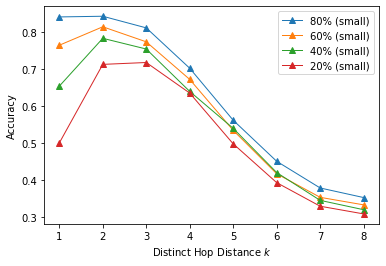

In [28]:
import matplotlib.pyplot as plt

plt.plot(range(1,9), nv_80, linewidth=1, label='80% (small)', marker="^")
plt.plot(range(1,9), nv_60, linewidth=1, label='60% (small)', marker="^")
plt.plot(range(1,9), nv_40, linewidth=1, label='40% (small)', marker="^")
plt.plot(range(1,9), nv_20, linewidth=1, label='20% (small)' , marker="^")

plt.xlabel(r'Distinct Hop Distance $k$')
plt.ylabel(r'Accuracy')
plt.legend()

In [0]:
import pandas as pd

res = list(zip(gt_lst, pred_lst))

df = pd.DataFrame(res)
df.to_csv("MV.csv", header=["gt", "pred"], index=False)

# Naive Random Ralk

In [0]:
rw_20_raw = []
rw_40_raw = []
rw_60_raw = []
rw_80_raw = []

In [0]:
rw_20 = []
rw_40 = []
rw_60 = []
rw_80 = []

In [0]:
NODE_NUM = len(Gnx.nodes())

labels = []
masks = []

with open('target_with_mask_40.csv', 'r') as f:
    next(f)
    if DATA_TYPE == 'raw':
        for row in f:
            nrow = row.strip('\n').split(',')
            paper_id = int(nrow[0])
            class_id = int(nrow[1].split("\t")[0])
            is_train = int(nrow[2])
            labels.append(class_id)
            masks.append(is_train)
    else:
        for row in f:
            nrow = row.strip('\n').split(',')
            paper_id = int(nrow[0])
            class_id = int(nrow[1])
            is_train = int(nrow[2])
            labels.append(class_id)
            masks.append(is_train)

labels = np.array(labels)
masks = np.array(masks)

In [0]:
LENGTH = [1,2,3,4,5,6,7,8,9]
TIME = 3
gt_lst = []
pred_lst = []

for l in LENGTH:

    for i in tqdm.tqdm_notebook(range(DATA_NUM)):
        if masks[i] == 1:
            cur_node = i
            visited_node = list()
            visited_label = np.zeros((CLASS_NUM,1))
            for t in range(TIME):
                for k in range(l):
                    next_node_lst = []
                    for node in Gnx.edges(cur_node):
                        next_node_lst.append(node[1])
                    if next_node_lst == []:
                        cur_node = np.random.choice(range(NODE_NUM),1)[0]
                    else:
                        cur_node = np.random.choice(next_node_lst, 1)[0]
                    if masks[cur_node] == 0:
                        visited_node.append(cur_node)
                        visited_label[int(labels[cur_node])] += 1
                    p = np.zeros((NODE_NUM,))
                    p[cur_node] = 1
                    p = p.reshape(-1,1)
            gt_lst.append(labels[i])
            pred_lst.append(randargmax(visited_label))

    ct = 0
    cor_ct = 0

    for pair in zip(gt_lst, pred_lst):
        if pair[0] == pair[1]:
            cor_ct += 1
        ct += 1

    print("Length = {} ".format(l))
    print('Acc: {:.4f}'.format(cor_ct/ct))

    rw_60.append(cor_ct/ct)

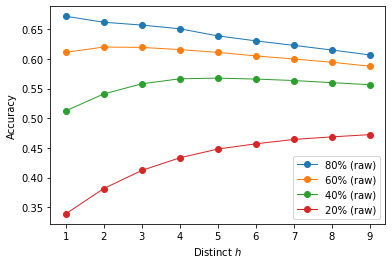

In [0]:
plt.plot(range(1,10), rw_80_raw, linewidth=1, label='80% (raw)', marker="o")
plt.plot(range(1,10), rw_60_raw, linewidth=1, label='60% (raw)', marker="o")
plt.plot(range(1,10), rw_40_raw, linewidth=1, label='40% (raw)', marker="o")
plt.plot(range(1,10), rw_20_raw, linewidth=1, label='20% (raw)', marker="o")

plt.xlabel(r'Distinct $h$')
plt.ylabel(r'Accuracy')
plt.legend()

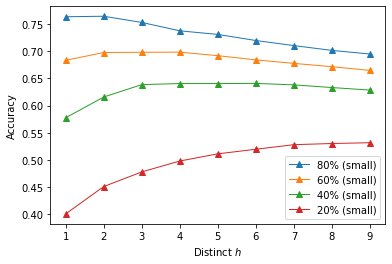

In [0]:
plt.plot(range(1,10), rw_80, linewidth=1, label='80% (small)', marker="^")
plt.plot(range(1,10), rw_60, linewidth=1, label='60% (small)', marker="^")
plt.plot(range(1,10), rw_40, linewidth=1, label='40% (small)', marker="^")
plt.plot(range(1,10), rw_20, linewidth=1, label='20% (small)', marker="^")

plt.xlabel(r'Distinct $h$')
plt.ylabel(r'Accuracy')
plt.legend()

In [0]:
print(rw_20[0],rw_20[2],rw_20[4])
print(rw_40[0],rw_40[2],rw_40[4])
print(rw_60[0],rw_60[2],rw_60[4])
print(rw_80[0],rw_80[2],rw_80[4])

NameError: ignored

In [0]:
import pandas as pd

res = list(zip(gt_lst, pred_lst))

df = pd.DataFrame(res)
df.to_csv("RW.csv", header=["gt", "pred"], index=False)